# Imports & basic setup

In [2]:
# Cell 2: Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Make plots a bit prettier
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)


# Download VADER lexicon

In [3]:
# Download VADER lexicon for sentiment analysis (only first time)
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...


In [9]:
# Cell 4: Create a synthetic dataset of bank app reviews

data = [
    {"review_text": "Exceptional product, very easy to use and fast.", "rating": 5},
    {"review_text": "The app is impressive and smooth. Great job Dashen Bank!", "rating": 5},
    {"review_text": "Good app but sometimes it is slow.", "rating": 3},
    {"review_text": "Bill payment options are limited, please add more services.", "rating": 2},
    {"review_text": "It is really slow and always crashing. Very frustrating!", "rating": 1},
    {"review_text": "Always updating, bad stability, I don't like it.", "rating": 1},
    {"review_text": "With the super app everything I need is just a tap away.", "rating": 5},
    {"review_text": "It's okay, nothing special but it works.", "rating": 3},
    {"review_text": "I disabled developer options but it still doesn't work.", "rating": 1},
    {"review_text": "Clean design, user friendly and reliable.", "rating": 4},
]

df = pd.DataFrame(data)
df.head()


,review_text,rating
0,"Exceptional product, very easy to use and fast.",5
1,The app is impressive and smooth. Great job Da...,5
2,Good app but sometimes it is slow.,3
3,"Bill payment options are limited, please add m...",2
4,It is really slow and always crashing. Very fr...,1


In [17]:
# Cell 4: Load dataset of bank app reviews from processed CSV (with a trailing newline)
from pathlib import Path
import pandas as pd

data = r"C:\Users\Administrator\Desktop\fintech-customer-experience-analytics\data\processed\reviews_processed.csv"

csv_path = Path(data)
if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found: {csv_path}")

# Load CSV and keep only the two required columns
df = pd.read_csv(csv_path, dtype=str)

required = {"review_text", "rating"}
missing = required - set(df.columns)
if missing:
    raise NameError(f"Loaded CSV is missing required column(s): {sorted(missing)}. Expected columns: {sorted(required)}.")

df = df[["review_text", "rating"]].copy()
df["review_text"] = df["review_text"].fillna("").astype(str)
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

# Preview
display(df.head())

# Print a newline for clarity in output
print()


,review_text,rating
0,good,5
1,አስደናቂ ነው ቀላለ ምቹ ፈጣን እና አካታች ነው። ከዚህ በበለጠ ብዙ ነገ...,5
2,Good,5
3,good,5
4,Very Useful and attractive app !,5


# Map star ratings → sentiment labels (for ML)

In [18]:
# Convert star rating to sentiment label (for supervised ML later)
def rating_to_label(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["sentiment_label"] = df["rating"].apply(rating_to_label)
df


,review_text,rating,sentiment_label
0,good,5,positive
1,አስደናቂ ነው ቀላለ ምቹ ፈጣን እና አካታች ነው። ከዚህ በበለጠ ብዙ ነገ...,5,positive
2,Good,5,positive
3,good,5,positive
4,Very Useful and attractive app !,5,positive
...,...,...,...
978,አዲሱ Update ጥሩ አይደለም. Update ካደረግኩት በኋላ ከዚህ በፊት...,2,negative
979,good,5,positive
980,this application do not show over all transact...,3,neutral
981,this app is very nice but statment history is ...,4,positive


# Frequency-Based vs TF-IDF
Basic text cleaning

In [21]:
# Preprocessing (lowercase)
df["clean_text"] = df["review_text"].str.lower()
df[["review_text", "clean_text"]]

,review_text,clean_text
0,good,good
1,አስደናቂ ነው ቀላለ ምቹ ፈጣን እና አካታች ነው። ከዚህ በበለጠ ብዙ ነገ...,አስደናቂ ነው ቀላለ ምቹ ፈጣን እና አካታች ነው። ከዚህ በበለጠ ብዙ ነገ...
2,Good,good
3,good,good
4,Very Useful and attractive app !,very useful and attractive app !
...,...,...
978,አዲሱ Update ጥሩ አይደለም. Update ካደረግኩት በኋላ ከዚህ በፊት...,አዲሱ update ጥሩ አይደለም. update ካደረግኩት በኋላ ከዚህ በፊት...
979,good,good
980,this application do not show over all transact...,this application do not show over all transact...
981,this app is very nice but statment history is ...,this app is very nice but statment history is ...


## Frequency-based representation (Bag of Words)

In [23]:
# Frequency-based word counts using CountVectorizer

count_vec = CountVectorizer(stop_words="english")
X_counts = count_vec.fit_transform(df["clean_text"])

# Sum counts for each word across all documents
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
vocab = np.array(count_vec.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)
freq_df.head(10)


,word,count
104,app,316
508,good,219
176,best,100
157,bank,69
749,nice,64
1145,use,48
1134,update,47
110,application,40
159,banking,39
428,fast,38


## Visualize top frequent words

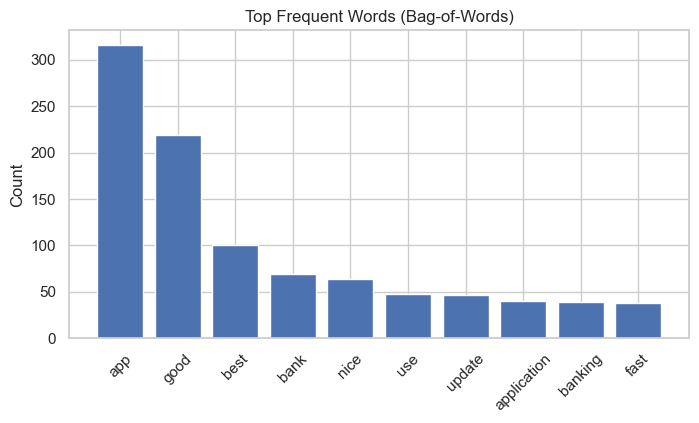

In [24]:
# Plot top frequent words (Frequency-Based)

top_n = 10
top_freq = freq_df.head(top_n)

plt.bar(top_freq["word"], top_freq["count"])
plt.xticks(rotation=45)
plt.title("Top Frequent Words (Bag-of-Words)")
plt.ylabel("Count")
plt.show()

## TF-IDF representation

In [28]:
# TF-IDF representation
tfidf_vec = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf_vec.fit_transform(df["clean_text"])

# Get average TF-IDF score per word across documents
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word": vocab_tfidf, "tfidf": tfidf_means})
tfidf_df = tfidf_df.sort_values("tfidf", ascending=False)
tfidf_df.head(10)


# Compare top words by frequency and by TF-IDF

print("Top 10 by raw frequency:")
display(freq_df.head(10))

print("\nTop 10 by TF-IDF (words more unique / informative):")
display(tfidf_df.head(10))

Top 10 by raw frequency:


,word,count
104,app,316
508,good,219
176,best,100
157,bank,69
749,nice,64
1145,use,48
1134,update,47
110,application,40
159,banking,39
428,fast,38



Top 10 by TF-IDF (words more unique / informative):


,word,tfidf
508,good,0.160225
104,app,0.088399
176,best,0.059833
749,nice,0.046342
409,excellent,0.026010
157,bank,0.021893
428,fast,0.018109
1145,use,0.015419
84,amazing,0.014520
110,application,0.014046


## Topic Modeling 

In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

import nltk
from nltk.corpus import stopwords

# Tokenize text (very simple split for demo)
df["tokens"] = df["clean_text"].str.split()

# Create dictionary and corpus for LDA
dictionary = Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]


# Download stopwords (only first time)
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
# Remove stopwords from your tokenized text
df["tokens_nostop"] = df["tokens"].apply(
    lambda words: [w for w in words if w not in stop_words]
)

df[["clean_text", "tokens", "tokens_nostop"]].head()


